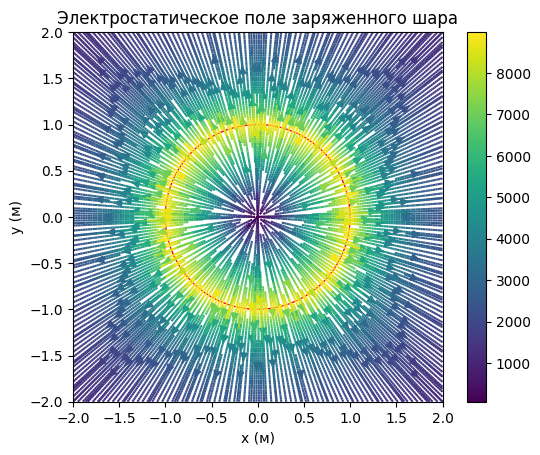

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Константы
epsilon_0 = 8.854187817e-12  # Электрическая постоянная, Ф/м
Q = 1e-6  # Заряд шара, Кл
R = 1.0  # Радиус шара, м

# Создание сетки точек в плоскости xy
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)

# Инициализация массивов для компонент поля
E_x = np.zeros_like(X)
E_y = np.zeros_like(Y)

# Вне шара
outside = r > R
E_x[outside] = (1 / (4 * np.pi * epsilon_0)) * (Q * X[outside]) / (r[outside]**3)
E_y[outside] = (1 / (4 * np.pi * epsilon_0)) * (Q * Y[outside]) / (r[outside]**3)

# Внутри шара
inside = r <= R
E_x[inside] = (1 / (4 * np.pi * epsilon_0)) * (Q * X[inside]) / (R**3)
E_y[inside] = (1 / (4 * np.pi * epsilon_0)) * (Q * Y[inside]) / (R**3)

# Визуализация поля
fig, ax = plt.subplots()
ax.streamplot(X, Y, E_x, E_y, color=np.sqrt(E_x**2 + E_y**2), cmap='viridis', density= 5)
circle = plt.Circle((0, 0), R, color='r', fill=False)
ax.add_artist(circle)
ax.set_xlabel('x (м)')
ax.set_ylabel('y (м)')
ax.set_title('Электростатическое поле заряженного шара')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(ax.streamplot(X, Y, E_x, E_y, color=np.sqrt(E_x**2 + E_y**2), cmap='viridis').lines)
plt.show()


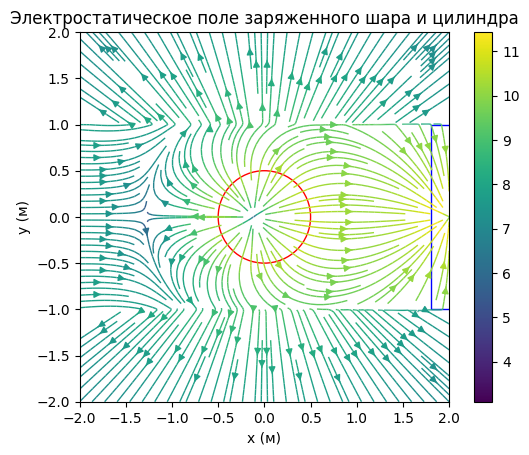

In [6]:


# Константы
epsilon_0 = 8.854187817e-12  # Электрическая постоянная, Ф/м
Q_s = 1e-6  # Заряд шара, Кл
R_s = 0.5  # Радиус шара, м
lambda_c = -1e-6  # Линейная плотность заряда цилиндра, Кл/м
R_c = 0.2  # Радиус цилиндра, м
h_c = 2.0  # Высота цилиндра, м
d = 2.0  # Смещение центра цилиндра по оси x от центра сферы, м

# Создание сетки точек в плоскости xy
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)

# Инициализация массивов для компонент поля
E_x = np.zeros_like(X)
E_y = np.zeros_like(Y)

# Поле от шара
outside = r > R_s
E_x[outside] = (1 / (4 * np.pi * epsilon_0)) * (Q_s * X[outside]) / (r[outside]**3)
E_y[outside] = (1 / (4 * np.pi * epsilon_0)) * (Q_s * Y[outside]) / (r[outside]**3)

inside = r <= R_s
E_x[inside] = (1 / (4 * np.pi * epsilon_0)) * (Q_s * X[inside]) / (R_s**3)
E_y[inside] = (1 / (4 * np.pi * epsilon_0)) * (Q_s * Y[inside]) / (R_s**3)

# Поле от цилиндра
def cylinder_field(X, Y, lambda_c, R_c, h_c, d):
    E_cx = np.zeros_like(X)
    E_cy = np.zeros_like(Y)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if np.abs(Y[i, j]) <= h_c / 2:
                x_shifted = X[i, j] - d
                r_c = np.sqrt(x_shifted**2 + Y[i, j]**2)
                if r_c >= R_c:
                    E_cx[i, j] = (lambda_c * x_shifted) / (2 * np.pi * epsilon_0 * r_c**2)
                    E_cy[i, j] = (lambda_c * Y[i, j]) / (2 * np.pi * epsilon_0 * r_c**2)
                else:
                    E_cx[i, j] = (lambda_c * x_shifted) / (2 * np.pi * epsilon_0 * R_c**2)
                    E_cy[i, j] = (lambda_c * Y[i, j]) / (2 * np.pi * epsilon_0 * R_c**2)
    return E_cx, E_cy

E_cx, E_cy = cylinder_field(X, Y, lambda_c, R_c, h_c, d)
E_x += E_cx
E_y += E_cy

# Визуализация поля
fig, ax = plt.subplots()
color = np.log(np.sqrt(E_x**2 + E_y**2))
strm = ax.streamplot(X, Y, E_x, E_y, color=color, linewidth=1, cmap='viridis', density=2)
circle = plt.Circle((0, 0), R_s, color='r', fill=False)
ax.add_artist(circle)
rect = plt.Rectangle((d - R_c, -h_c/2), 2*R_c, h_c, color='b', fill=False)
ax.add_artist(rect)
ax.set_xlabel('x (м)')
ax.set_ylabel('y (м)')
ax.set_title('Электростатическое поле заряженного шара и цилиндра')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(strm.lines)
plt.show()


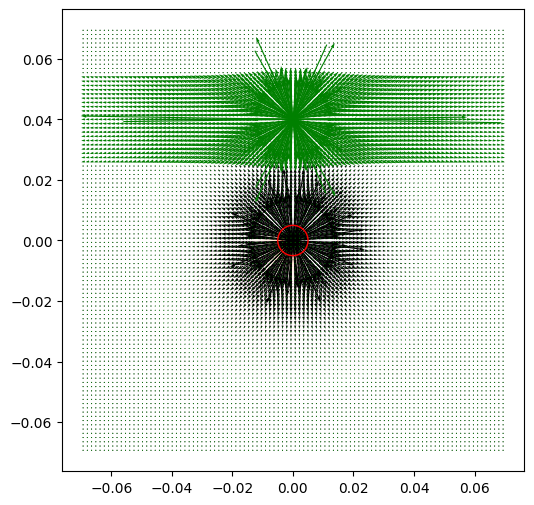

In [10]:
import recoil_nuclear_classes_and_defs as cnst
# Определяем размеры сетки
#если принять размер сферы за единицу то пространство вне сферы будет составлять плоскость 9х9
x_min = -0.07 # m
x_max = 0.07
y_min, y_max = -0.07 , 0.07 

# Создание сетки пространства
num_points = 1000
x = np.linspace(x_min, x_max, num_points)
y = np.linspace(y_min, y_max, num_points)
X_axis, Y_axis = np.meshgrid(x, y)

#Определяем емкость и заряд электродов
r_sphere = 0.005 #metrs
l_needle = 0.03 #metrs
r_needle = 0.0001 #metrs

volume_sph = (4/3) * np.pi * r_sphere**3
c_sphere = 4*np.pi*cnst.EPS0*r_sphere
#емкость иглы как емкость цилиндра
c_needle = (2*np.pi*cnst.EPS0*l_needle)/(np.log(2*l_needle/r_needle))
# Определяем напряжение
u = 2000 # Volt
# Координаты точечных зарядов
q_sphere_x, q_sphere_y = 0, 0  # заряд находится в центре

q_needl_x, q_needl_y = 0, 0.04

# Величина зарядов
q_sph = c_sphere*u  # в кулонах
q_needl = c_needle*u # Kl

q_sph_vol = q_sph/ volume_sph
# Константа Кулона
k = 8.9875517873681764e9  # Н·м²/Кл²

E_ins_sph = float(( q_sph_vol * r_sphere ) / (3*cnst.EPS0))



E_s_x = np.zeros((num_points, num_points), dtype=float)
E_s_y = np.zeros((num_points, num_points), dtype=float)
E_n_x = np.zeros((num_points, num_points), dtype=float)
E_n_y = np.zeros((num_points, num_points), dtype=float)



radius_vecror = np.sqrt(X_axis**2 + Y_axis**2)

outside = radius_vecror > r_sphere
E_s_x[outside] = (1 / (4 * np.pi * cnst.EPS0)) * (q_sph * X_axis[outside]) / (radius_vecror[outside]**3)
E_s_y[outside] = (1 / (4 * np.pi * cnst.EPS0)) * (q_sph * Y_axis[outside]) / (radius_vecror[outside]**3)

inside = radius_vecror <= r_sphere
E_s_x[inside] = 0
E_s_y[inside] = 0
 

def cylinder_field(X, Y, lambda_c, R_c, h_c, d_y):
    epsilon_0 = 8.854187817e-12  # Вакуумная диэлектрическая проницаемость
    
    E_cx = np.zeros_like(X)
    E_cy = np.zeros_like(Y)
    
    # Маска для точек внутри высоты цилиндра с учетом смещения по оси Y
    mask_height = np.abs(Y - d_y) <= h_c / 2
    
    # Смещенные координаты
    Y_shifted = Y - d_y
    
    # Расстояние до оси цилиндра
    r_c = np.sqrt(X**2 + Y_shifted**2)
    
    # Внешнее поле (r >= R_c)
    mask_outside = (r_c >= R_c) & mask_height
    E_cx[mask_outside] = (lambda_c * X[mask_outside]) / (2 * np.pi * epsilon_0 * r_c[mask_outside]**2)
    E_cy[mask_outside] = (lambda_c * Y_shifted[mask_outside]) / (2 * np.pi * epsilon_0 * r_c[mask_outside]**2)
    
    # Внутреннее поле (r < R_c)
    mask_inside = (r_c < R_c) & mask_height
    E_cx[mask_inside] = (lambda_c * X[mask_inside]) / (2 * np.pi * epsilon_0 * R_c**2)
    E_cy[mask_inside] = (lambda_c * Y_shifted[mask_inside]) / (2 * np.pi * epsilon_0 * R_c**2)
    
    return E_cx, E_cy

E_cx, E_cy = cylinder_field(X_axis, Y_axis, q_needl, r_needle, l_needle, d_y=0.04)
E_n_x += E_cx
E_n_y += E_cy




E_s_res = E_s_x + E_s_y


E_n_res = E_n_x + E_n_y

# Results
E_res_x = E_n_x + E_s_x
E_res_y = E_n_y + E_s_y
E_res = E_res_x + E_res_y





fig, ax= plt.subplots(figsize=(10, 6))
cbr=ax.imshow(E_res, origin="lower", extent=(-0.045, 0.045, -0.045, 0.045), cmap="RdGy")
ax.quiver(X_axis[5::10, 5::10], Y_axis[5::10, 5::10], E_res_x[5::10, 5::10], E_res_y[5::10, 5::10], pivot = "middle", color = "black")
ax.quiver(X_axis[5::10, 5::10], Y_axis[5::10, 5::10], E_n_x[5::10, 5::10], E_n_y[5::10, 5::10], pivot = "middle", color = "green")
circle = plt.Circle((0, 0), r_sphere, color='r', fill=False)
ax.add_artist(circle)



plt.show()


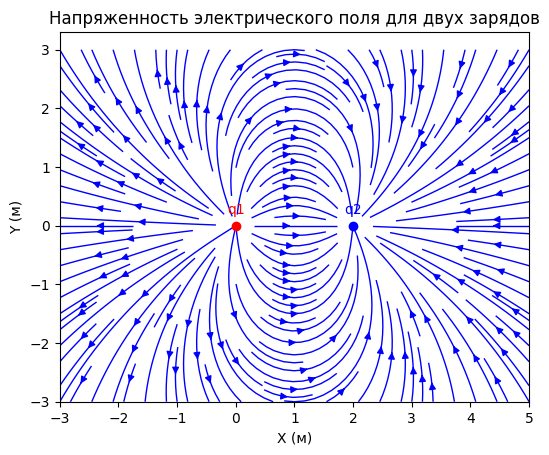

In [4]:

# Константы
k_e = 8.987e9  # Н·м^2/Кл^2

# Заряды и их координаты
q1, q2 = 1e-9, -1e-9  # Кл (можно изменить значения зарядов)
r1, r2 = 1, 0.05  # м (радиусы сфер, хотя в расчете они не участвуют напрямую)
pos1 = np.array([0, 0])  # Первая сфера в начале координат
pos2 = np.array([2, 0])  # Вторая сфера на расстоянии 2 м

# Определим сетку координат для расчета поля
x = np.linspace(-3, 5, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

# Функция для расчета напряженности поля
def electric_field(q, pos, X, Y):
    Rx = X - pos[0]
    Ry = Y - pos[1]
    R = np.sqrt(Rx**2 + Ry**2)
    Ex = k_e * q * Rx / R**3
    Ey = k_e * q * Ry / R**3
    return Ex, Ey

# Рассчитаем поля от каждого заряда
E1x, E1y = electric_field(q1, pos1, X, Y)
E2x, E2y = electric_field(q2, pos2, X, Y)

# Суммируем векторы полей
Ex = E1x + E2x
Ey = E1y + E2y

# Построим график
fig, ax = plt.subplots()
ax.streamplot(X, Y, Ex, Ey, color='b', linewidth=1, density=1.5)
ax.set_aspect('equal')
ax.set_title('Напряженность электрического поля для двух зарядов')
ax.set_xlabel('X (м)')
ax.set_ylabel('Y (м)')

# Добавим заряды на график
ax.plot(pos1[0], pos1[1], 'ro')  # положительный заряд
ax.plot(pos2[0], pos2[1], 'bo')  # отрицательный заряд
ax.text(pos1[0], pos1[1] + 0.2, 'q1', color='red', ha='center')
ax.text(pos2[0], pos2[1] + 0.2, 'q2', color='blue', ha='center')

plt.show()


In [11]:
#мой код
import recoil_nuclear_classes_and_defs as cnst
# Определяем размеры сетки
#если принять размер сферы за единицу то пространство вне сферы будет составлять плоскость 9х9
x_min = -0.07 # m
x_max = 0.07
y_min, y_max = -0.07 , 0.07 

# Создание сетки пространства
num_points = 1000
x = np.linspace(x_min, x_max, num_points)
y = np.linspace(y_min, y_max, num_points)
X_axis, Y_axis = np.meshgrid(x, y)

#Определяем емкость и заряд электродов
r_sphere = 0.005 #metrs
l_needle = 0.03 #metrs
r_needle = 0.001 #metrs

volume_sph = (4/3) * np.pi * r_sphere**3
c_sphere = 4*np.pi*cnst.EPS0*r_sphere
#емкость иглы как емкость цилиндра
c_needle = (2*np.pi*cnst.EPS0*l_needle)/(np.log(2*l_needle/r_needle))
# Определяем напряжение
u = 100 # Volt
# Координаты точечных зарядов
q_sphere_x, q_sphere_y = 0, 0  # заряд находится в центре

q_needl_x, q_needl_y = 0, 0.045 # конец иглы находится на расстоянии 4 см от центра сферы

# Величина зарядов
q_sph = c_sphere*u  # в кулонах
q_needl = -c_needle*u # Kl


# Константа Кулона
k = 8.9875517873681764e9  # Н·м²/Кл²

E_s_x = np.zeros((num_points, num_points), dtype=float)
E_s_y = np.zeros((num_points, num_points), dtype=float)
E_n_x = np.zeros((num_points, num_points), dtype=float)
E_n_y = np.zeros((num_points, num_points), dtype=float)


In [ ]:
radius_vecror = np.sqrt(X_axis**2 + Y_axis**2)

#Расчитываем поле вокруг заряженой сферы 
outside = radius_vecror > r_sphere
E_s_x[outside] = abs(1 / (4 * np.pi * cnst.EPS0)) * (q_sph * X_axis[outside]) / (radius_vecror[outside]**3)
E_s_y[outside] = abs(1 / (4 * np.pi * cnst.EPS0)) * (q_sph * Y_axis[outside]) / (radius_vecror[outside]**3)

inside = radius_vecror <= r_sphere
E_s_x[inside] = abs(1 / (4 * np.pi * cnst.EPS0)) * (q_sph * X_axis[inside]) / (r_sphere**3)
E_s_y[inside] = abs(1 / (4 * np.pi * cnst.EPS0)) * (q_sph * Y_axis[inside]) / (r_sphere**3)


# Расчитываем поле для наконечника иглы (предствляя ее как сферу)

#Расчитываем поле от основной части иглы (представляя его цилиндром)

def cylinder_field(X, Y, lambda_c, R_c, h_c, d_y):
    epsilon_0 = 8.854187817e-12  # Вакуумная диэлектрическая проницаемость
    
    E_cx = np.zeros_like(X)
    E_cy = np.zeros_like(Y)
    
    # Маска для точек внутри высоты цилиндра с учетом смещения по оси Y
    mask_height = np.abs(Y - d_y) <= h_c / 2
    
    # Смещенные координаты
    Y_shifted = Y - d_y
    
    # Расстояние до оси цилиндра
    r_c = np.sqrt(X**2 + Y_shifted**2)
    
    # Внешнее поле (r >= R_c)
    mask_outside = (r_c >= R_c) & mask_height
    E_cx[mask_outside] = abs((lambda_c * X[mask_outside]) / (2 * np.pi * epsilon_0 * r_c[mask_outside]**2))
    E_cy[mask_outside] = abs((lambda_c * Y_shifted[mask_outside]) / (2 * np.pi * epsilon_0 * r_c[mask_outside]**2))
    
    # Внутреннее поле (r < R_c)
    mask_inside = (r_c < R_c) & mask_height
    # E_cx[mask_inside] = (lambda_c * X[mask_inside]) / (2 * np.pi * epsilon_0 * R_c**2)
    # E_cy[mask_inside] = (lambda_c * Y_shifted[mask_inside]) / (2 * np.pi * epsilon_0 * R_c**2)
    
    return E_cx, E_cy

E_cx, E_cy = cylinder_field(X_axis, Y_axis, q_needl, r_needle, l_needle, d_y = q_needl_y)
E_n_x += E_cx
E_n_y += E_cy



# for i in range(len(X_axis)):
#     for j in range(len(Y_axis)):
        
#         R_s = np.sqrt((X_axis[j, i] - q_sphere_x)**2 + (Y_axis[j, i] - q_sphere_y)**2)
        
#         if np.sqrt(X_axis[j, i]**2 + Y_axis[j, i]**2) < 0.005:
#             E_s_x[j, i] = float(( q_sph_vol * R_s ) / (3*cnst.EPS0))
#             E_s_y[j, i] = float(( q_sph_vol * R_s ) / (3*cnst.EPS0))
            
            
        
#         # Вычисление электрического поля в каждой точке сетки для сферы
#         else:
#             E_s_x[j, i] = k * q_sph * (abs(X_axis[j, i] - q_sphere_x)) / R_s**2
#             E_s_y[j, i] = k * q_sph * (abs(Y_axis[j, i] - q_sphere_y)) / R_s**2
            
#             # Вычисление электрического поля в каждой точке сетки для иглы
#             R_l = np.sqrt((X_axis[j, i] - q_needl_x)**2 + (Y_axis[j, i] - q_needl_y)**2)
#             E_n_x[j, i] = k * q_needl * (abs(X_axis[j, i] - q_needl_x)) / R_l**2
#             E_n_y[j, i] = k * q_needl * (abs(Y_axis[j, i] - q_needl_y)) / R_l**2



E_s_res = E_s_x + E_s_y


E_n_res = E_dot_x + E_dot_y + E_cx + E_cy

# Results
E_res_x = E_dot_x + E_cx + E_s_x
E_res_y = E_dot_y + E_cy  + E_s_y
E_res = E_res_x + E_res_y




# plot data

fig, ax= plt.subplots(figsize=(10, 6))
cbr=ax.imshow(E_res, origin="lower", extent=(x_min, x_max, y_min, x_max), cmap="RdGy")

#ax.quiver(X_axis[5::10, 5::10], Y_axis[5::10, 5::10], E_s_x[5::10, 5::10], E_s_y[5::10, 5::10], pivot = "middle", color = "red")
#ax.quiver(X_axis[5::10, 5::10], Y_axis[5::10, 5::10], E_res_x[5::10, 5::10], E_res_y[5::10, 5::10], pivot = "middle", color = "green")
circle = plt.Circle((0, 0), r_sphere, color='r', fill=False)
ax.add_artist(circle)
# rect = plt.Rectangle((r_needle, l_needle/2), 2*r_needle, 0.04+l_needle, color='b', fill=False)
# ax.add_artist(rect)
fig.colorbar(cbr, ax=ax, cmap = "grey")

# fig2, ax2 = plt.subplots(figsize=(10, 6))
# cbr1=ax2.contour(X_axis, Y_axis, E_res, origin = "lower", extent=(-0.045, 0.045, -0.045, 0.045), cmap = "RdGy")
# fig.colorbar(cbr1, ax=ax2, cmap = "RdGy")
# ax2.grid()

# fig1, ax1 = plt.subplots()
# ax1.streamplot(X_axis, Y_axis, E_res_x, E_res_y, color='b', linewidth=1, density=1.5)
# ax1.set_aspect('equal')
# ax1.set_title('Напряженность электрического поля для двух зарядов')
# ax1.set_xlabel('X (м)')
# ax1.set_ylabel('Y (м)')

# Добавим заряды на график
# ax.plot(pos1[0], pos1[1], 'ro')  # положительный заряд
# ax.plot(pos2[0], pos2[1], 'bo')  # отрицательный заряд
# ax.text(pos1[0], pos1[1] + 0.2, 'q1', color='red', ha='center')
# ax.text(pos2[0], pos2[1] + 0.2, 'q2', color='blue', ha='center')
figg, axx = plt.subplots()
cbb=axx.imshow(E_n_res, origin="lower", extent=(x_min, x_max, y_min, x_max), cmap="RdGy")
figg.colorbar(cbb, ax=axx, cmap = "RdGy")
plt.show()

